In [1]:

from MuZero import MuZero

from GridWorldOption import GridWorldOption, GridWorldMacroAction


from GridWorld import GridWorld

from mcts.MCTS import MCTS
import numpy as np
import matplotlib.pyplot as plt

import random
from copy import deepcopy
import time

import pickle
import pandas as pd

from matplotlib.pyplot import figure
import itertools
from tqdm import tqdm


np.random.seed(52)
random.seed(52)

In [2]:
MAP_NAME = './maps/den204d_hard.map'

options = [
      GridWorldOption((0, 0),  {'all'}, 0, 0),
      GridWorldOption((0, 0),  {'all'}, 1, 1),
      GridWorldOption((0, 0),  {'all'}, 2, 2),
      GridWorldOption((0, 0),  {'all'}, 3, 3)
]

with open(MAP_NAME) as f:
    the_map = f.read()

In [3]:
SIMULATIONS = 40
SIM_FINISHS = 30000
GAMES = 500
ALPHA=0.01

In [4]:
env = GridWorld(the_map, SIM_FINISHS)
mu = MuZero(env, options)

In [5]:
start = time.time()
returns, argmax_returns = mu.learn(GAMES, SIMULATIONS, alpha=ALPHA)
end = time.time()

100%|██████████| 500/500 [1:17:47<00:00,  9.33s/it] 


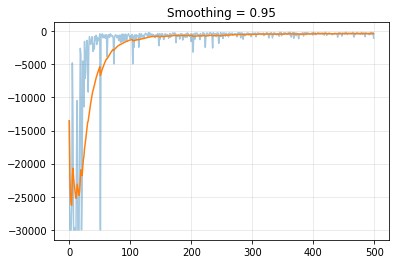

In [6]:
df = pd.DataFrame(data = {'value': np.array(returns[0:])})

SMOOTHING = 0.95
smooth = df.ewm(alpha=(1 - SMOOTHING)).mean()


plt.plot(df["value"], alpha=0.4)
plt.plot(smooth["value"])
plt.title("Smoothing = {}".format(SMOOTHING))
plt.grid(alpha=0.3)

plt.show()

In [7]:
starting_room_positions = set([(i,j) for i in range(25) for j in range(40,65)])

options = [
    # primitives, (0,0) is meaningless
    GridWorldOption((0, 0),   {'all'}, 0, 0),
    GridWorldOption((0, 0),   {'all'}, 1, 1),
    GridWorldOption((0, 0),   {'all'}, 2, 2),
    GridWorldOption((0, 0),   {'all'}, 3, 3),
    GridWorldOption((25, 50),  starting_room_positions, 4),
]

with open(MAP_NAME) as f:
    the_map = f.read()
    
env = GridWorld(the_map, SIM_FINISHS)
mu_ma = MuZero(env, options)

start_ma = time.time()
returns_ma, argmax_returns_ma = mu_ma.learn(GAMES, SIMULATIONS, alpha=ALPHA)
end_ma = time.time()

100%|██████████| 500/500 [19:14<00:00,  2.31s/it] 


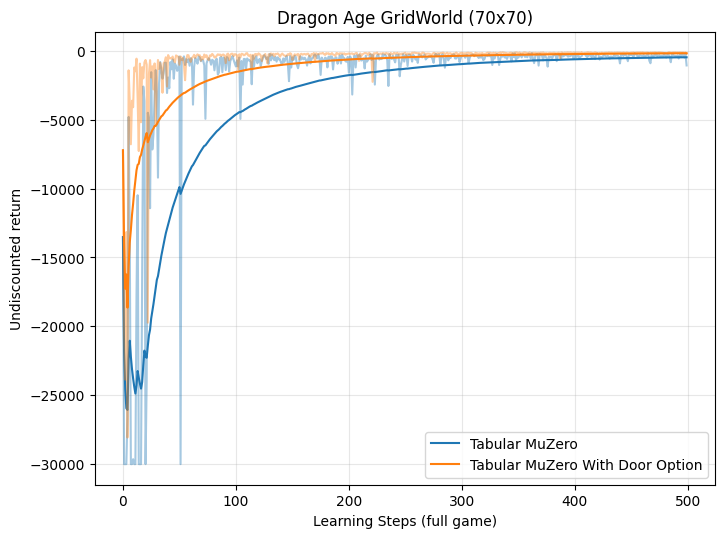

In [46]:
df = pd.DataFrame(data = {'value': np.array(returns[:])})
df_ma = pd.DataFrame(data = {'value': np.array(returns_ma[:])})

figure(figsize=(8, 6), dpi=100)

SMOOTHING = 0.99
smooth = df.ewm(alpha=(1 - SMOOTHING)).mean()
smooth_ma = df_ma.ewm(alpha=(1 - SMOOTHING)).mean()

plt.plot(df["value"], alpha=0.4, color='#1f77b4')
plt.plot(smooth["value"], color='#1f77b4', label='Tabular MuZero')
plt.plot(df_ma["value"], alpha=0.4, color='#ff7f0e')
plt.plot(smooth_ma["value"], color='#ff7f0e', label='Tabular MuZero With Door Option')

plt.title("Dragon Age GridWorld (70x70)".format(SMOOTHING))
plt.grid(alpha=0.3)

plt.xlabel("Learning Steps (full game)")
plt.ylabel("Undiscounted return")
plt.legend()
plt.show()

In [47]:
env = GridWorld(the_map, 1000)
env.reset()

total_return = 0
done = False

states = []
options = []
mu_p = mu_ma
while not done:
    s0 = mu_p.h.forward(env)

    mcts = MCTS(s0, mu_p.f, mu_p.g, mu_p.options)
    p, v = mcts.pred_model.forward(s0, [])
    pi = mcts.run_sim(40)

    opt = np.random.choice(mu_p.options, 1, p=pi)[0]
    #print(p)
    #print(pi)
    #opt_index = np.argmax(p)
    #opt = mu_p.options[opt_index]
    
    options.append(opt)
    states_by_opt = []
    while True:
        action, should_break = opt.get_action(env)
        
        if action == -1 or done:
            break
        
        s, r, done = env.step(action)
        states_by_opt.append(s)
        

        total_return += r
        
        if should_break:
            break
        
    states.append(states_by_opt)

print(total_return)

with open(MAP_NAME) as f:
    env_map = f.read()
    
env_map = env_map.split('\n')[4:]


grid = np.zeros((len(env_map), len(env_map[0])))
for i in range(len(env_map)):
    for j in range(len(env_map[0])):
        if env_map[i][j] != '.':
            grid[i][j] = -1
        else:
            grid[i][j] = 0

-137.0


[]

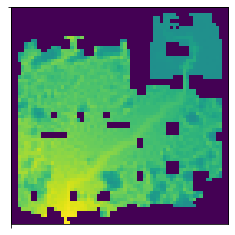

In [48]:
mini = min(mu_p.f.v_table.values())
maxi = max(mu_p.f.v_table.values())
for k, v in mu.f.v_table.items():
    grid[k] = (v - mini)/(maxi-mini)

_, ax = plt.subplots()
ax.imshow(grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()

[]

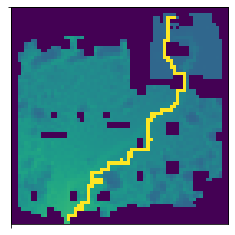

In [49]:
play_grid = deepcopy(grid)

for so in states:
    for s in so:
        play_grid[s] = 2
    
_, ax = plt.subplots()
ax.imshow(play_grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()

In [50]:
with open('results/mu_30.pickle', 'wb') as f:
    pickle.dump(mu, f)

In [51]:
with open('results/mu_ma_30.pickle', 'wb') as f:
    pickle.dump(mu_ma, f)

In [52]:
options = [
    # primitives, (0,0) is meaningless
    GridWorldOption((0, 0),   {'all'}, 0, 0),
    GridWorldOption((0, 0),   {'all'}, 1, 1),
    GridWorldOption((0, 0),   {'all'}, 2, 2),
    GridWorldOption((0, 0),   {'all'}, 3, 3),
    GridWorldMacroAction(0, 3, 4),
    GridWorldMacroAction(1, 3, 5),
    GridWorldMacroAction(2, 3, 6),
    GridWorldMacroAction(3, 3, 7),
]

with open(MAP_NAME) as f:
    the_map = f.read()
    
env = GridWorld(the_map, SIM_FINISHS)
mu_macro = MuZero(env, options)

start_macro = time.time()
returns_mu_macros, argmax_returns_macro = mu_macro.learn(GAMES, SIMULATIONS, alpha=ALPHA)
end_macro = time.time()

100%|██████████| 500/500 [13:07<00:00,  1.58s/it] 


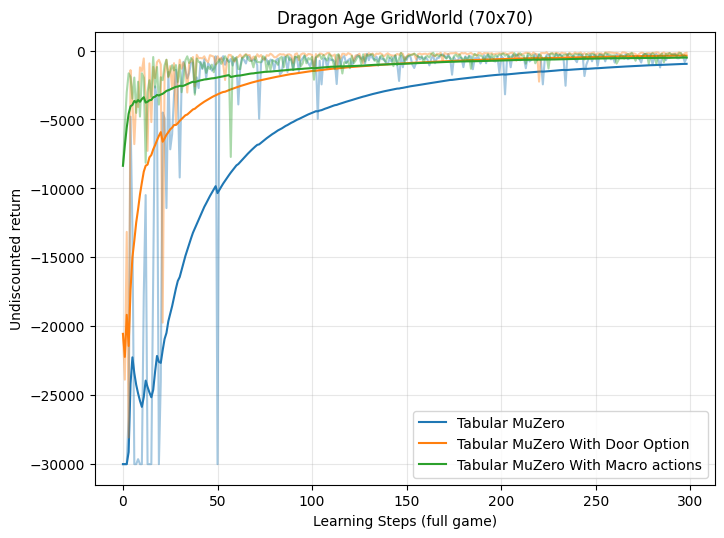

In [65]:
df = pd.DataFrame(data = {'value': np.array(returns[1:300])})
df_ma = pd.DataFrame(data = {'value': np.array(returns_ma[1:300])})
df_macro = pd.DataFrame(data = {'value': np.array(returns_mu_macros[1:300])})


figure(figsize=(8, 6), dpi=100)

SMOOTHING = 0.99
smooth = df.ewm(alpha=(1 - SMOOTHING)).mean()
smooth_ma = df_ma.ewm(alpha=(1 - SMOOTHING)).mean()
smooth_macro = df_macro.ewm(alpha=(1 - SMOOTHING)).mean()

plt.plot(df["value"], alpha=0.4, color='#1f77b4')
plt.plot(smooth["value"], color='#1f77b4', label='Tabular MuZero')
plt.plot(df_ma["value"], alpha=0.4, color='#ff7f0e')
plt.plot(smooth_ma["value"], color='#ff7f0e', label='Tabular MuZero With Door Option')
plt.plot(df_macro["value"], alpha=0.4, color='#2ca02c')
plt.plot(smooth_macro["value"], color='#2ca02c', label='Tabular MuZero With Macro actions')

plt.title("Dragon Age GridWorld (70x70)".format(SMOOTHING))
plt.grid(alpha=0.3)

plt.xlabel("Learning Steps (full game)")
plt.ylabel("Undiscounted return")
plt.legend()
plt.show()

-181.0


[]

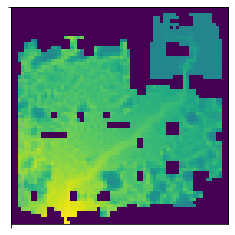

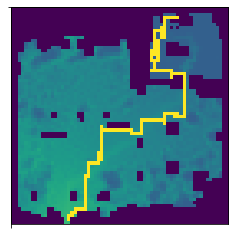

In [62]:
env = GridWorld(the_map, 1000)
env.reset()

total_return = 0
done = False

states = []
options = []
mu_p = mu_macro
while not done:
    s0 = mu_p.h.forward(env)

    mcts = MCTS(s0, mu_p.f, mu_p.g, mu_p.options)
    p, v = mcts.pred_model.forward(s0, [])
    pi = mcts.run_sim(40)

    opt = np.random.choice(mu_p.options, 1, p=pi)[0]
    #print(p)
    #print(pi)
    #opt_index = np.argmax(pi)
    #opt = mu_p.options[opt_index]
    
    options.append(opt)
    states_by_opt = []
    while True:
        action, should_break = opt.get_action(env)
        
        if action == -1 or done:
            break
        
        s, r, done = env.step(action)
        states_by_opt.append(s)
        

        total_return += r
        
        if should_break:
            break
        
    states.append(states_by_opt)

print(total_return)

with open(MAP_NAME) as f:
    env_map = f.read()
    
env_map = env_map.split('\n')[4:]


grid = np.zeros((len(env_map), len(env_map[0])))
for i in range(len(env_map)):
    for j in range(len(env_map[0])):
        if env_map[i][j] != '.':
            grid[i][j] = -1
        else:
            grid[i][j] = 0

mini = min(mu_p.f.v_table.values())
maxi = max(mu_p.f.v_table.values())
for k, v in mu.f.v_table.items():
    grid[k] = (v - mini)/(maxi-mini)

_, ax = plt.subplots()
ax.imshow(grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()

play_grid = deepcopy(grid)

for so in states:
    for s in so:
        play_grid[s] = 2
    
_, ax = plt.subplots()
ax.imshow(play_grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()